<a href="https://colab.research.google.com/github/cpeluso/HW3-Deep-Domain-Adaptation/blob/master/HW3_Deep_Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

!rm -rf "./DANN"
!rm -rf "./PACS"

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

import numpy as np
from google.colab import output

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

output.clear()

**Set Arguments, Define Data Preprocessing, Prepare Datasets, DataLoader and Network**

In [0]:
class Loader():
  def __init__(self):
    pass

  def load_default_parameters(self):
    default_DEVICE = 'cuda'
    default_NUM_CLASSES = 7
    default_NUM_DOMAINS = 2 
    default_BATCH_SIZE = 256 
    default_LR = 0.001           
    default_MOMENTUM = 0.9      
    default_WEIGHT_DECAY = 5e-5  
    default_NUM_EPOCHS = 30
    default_STEP_SIZE = 20   
    default_GAMMA = 0.1    
    default_LOG_FREQUENCY = 10
    default_IMAGE_SIZE = 224
    return (default_DEVICE, default_NUM_CLASSES, default_NUM_DOMAINS, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY, default_IMAGE_SIZE)
    pass

  def load_default_transformations(self):
    return (transforms.Compose([
      transforms.Resize(256),      
      transforms.CenterCrop(224),                            
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ]),
    transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
    ]))
    pass

  def clone_repositories(self):
    # Clone github repository with data
    if not os.path.isdir('./PACS'):
      !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
      !mv 'Homework3-PACS' 'PACS'

    # Clone personal github repository with DANN model class
    if not os.path.isdir('./DANN'):
      !git clone https://github.com/cpeluso/HW3-Deep-Domain-Adaptation.git
      !mv 'HW3-Deep-Domain-Adaptation' 'DANN'
    
    pass

  def load_datasets(self):
    global train_transform, test_transform

    DATA_DIR = [
      "PACS/PACS/art_painting",
      "PACS/PACS/cartoon",
      "PACS/PACS/photo",
      "PACS/PACS/sketch"
    ]

    return (ImageFolder(DATA_DIR[2], transform = train_transform),
            ImageFolder(DATA_DIR[0], transform = test_transform),
            ImageFolder(DATA_DIR[1]),
            ImageFolder(DATA_DIR[3]))
    pass

  def load_dataloaders(self):
    global train_dataset, test_dataset, cartoon_dataset, sketch_dataset
    
    return (DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True),
            DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4))
    pass

  def load_dann(self, dann):
    # Apply weights of pretrained AlexNet also to the domain classifier branch
    for classifier_layer, dann_classifier_layer in zip(dann.classifier, dann.dann_classifier):
      if type(classifier_layer) is torch.nn.modules.linear.Linear:
        dann_classifier_layer.weight.data = classifier_layer.weight.data
        dann_classifier_layer.bias.data = classifier_layer.bias.data

    # Change number of outputs of last fully connected layers of classifier and domain classifier
    dann.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    dann.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

    return dann
    pass

  def load_scheduler_optimizer(self, dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA):

    parameters_to_optimize = dann.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    return optimizer, scheduler 
    pass

In [0]:
class Utility():
  def __init__(self):
    pass
    
  def plot_losses(self, classifier_losses = [], discriminator_source_losses = [], discriminator_target_losses = []):

    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    if classifier_losses != []:
      classifier_loss_df = pd.DataFrame(classifier_losses)
      classifier_loss_df = classifier_loss_df.astype(float)
      classifier_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=classifier_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")


    if discriminator_source_losses != []:
      discriminator_source_loss_df = pd.DataFrame(discriminator_source_losses)
      discriminator_source_loss_df = discriminator_source_loss_df.astype(float)
      discriminator_source_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_source_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")
    
    if discriminator_source_losses != []:
      discriminator_target_loss_df = pd.DataFrame(discriminator_source_losses)
      discriminator_target_loss_df = discriminator_target_loss_df.astype(float)
      discriminator_target_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_target_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")

    pass

  def plot_accuracies(self, classifier_accuracies = []):
    classifier_accuracies_df = pd.DataFrame(classifier_accuracies)
    classifier_accuracies_df = classifier_accuracies_df.astype(float)
    classifier_accuracies_df.columns=['Epoch','Accuracy']

    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    sns.lineplot(x='Epoch',y='Accuracy',data=classifier_accuracies_df, markers=True, dashes=False,  ax = ax)
    pass

In [0]:
class TrainValidateTestManager():
  def __init__(self):
    pass
  
  def train_network_without_adaptation(self, dann, util):
    global dataloader_source, train_dataset, NUM_EPOCHS
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    classifier_losses = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        source = source_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      
      print("Classifier accuracy: ", str(accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))

      classifier_accuracies.append( (epoch + 1, accuracy) )
      classifier_losses.append( (epoch + 1, classifier_loss.item()) )

    output.clear()
    util.plot_accuracies(classifier_accuracies)
    util.plot_losses(classifier_losses)
    pass
  
  def train_network_with_adaptation(self, dann, util, LAMBDA):
    global dataloader_source, train_dataset, NUM_EPOCHS, BATCH_SIZE
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    classifier_losses = []
    discriminator_source_losses = []
    discriminator_target_losses = []
    short_discriminator_target_labels = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        target_images, target_set = sample_target(current_step, BATCH_SIZE)

        source = source_images.to(DEVICE)
        target = target_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Forward source data to the discriminator branch of the network
        discriminator_output_source = dann(source, LAMBDA)
        discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
        discriminator_loss_source.backward()

        # Forward target data to the discriminator branch of the network
        discriminator_output_target = dann(target, LAMBDA)
        if BATCH_SIZE != len(discriminator_output_target):

          # Define short_discriminator_target_labels if not defined yet
          short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
        
          discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      
        else:
          
          discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

        discriminator_loss_target.backward()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      
      print("Classifier accuracy: ", str(accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))
      print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
      print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

      classifier_accuracies.append( (epoch + 1, accuracy) )
      classifier_losses.append( (epoch + 1, classifier_loss.item()) )
      discriminator_source_losses.append( (epoch + 1, discriminator_loss_source.item()) )
      discriminator_target_losses.append( (epoch + 1, discriminator_loss_target.item()) )

    output.clear()
    util.plot_accuracies(classifier_accuracies)
    util.plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses)

  def test_network(self, dann, dataloader_target):

    # Set Network to evaluation mode
    dann.train(False) 

    running_corrects = 0
    for images, labels in tqdm(dataloader_target):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = dann(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('\nTest Accuracy: {}'.format(accuracy))
    pass


In [6]:
loader = Loader()
util = Utility()
manager = TrainValidateTestManager()

DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_default_parameters()
 
train_transform, test_transform = loader.load_default_transformations()

loader.clone_repositories()
from DANN.DANN import RandomNetworkWithReverseGrad

train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 42.51 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.
Cloning into 'HW3-Deep-Domain-Adaptation'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


**Prepare Training**

In [0]:
target_set = iter(dataloader_target)
def sample_target(step, n_batches):
    global target_set
    if step % n_batches == 0:
        target_set = iter(dataloader_target)
    return target_set.next()

target_set_cartoon = iter(dataloader_target_cartoon)
def sample_target(step, n_batches):
    global target_set_cartoon
    if step % n_batches == 0:
        target_set_cartoon = iter(dataloader_target_cartoon)
    return target_set_cartoon.next()

target_set_sketch = iter(dataloader_target_sketch)
def sample_target(step, n_batches):
    global target_set_sketch
    if step % n_batches == 0:
        target_set_sketch = iter(dataloader_target_sketch)
    return target_set_sketch.next()


**Train**

<Figure size 432x288 with 0 Axes>

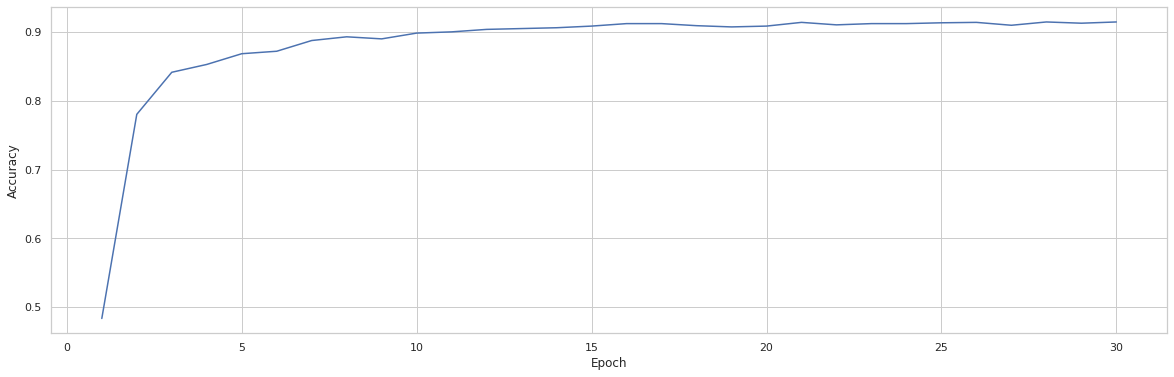

<Figure size 432x288 with 0 Axes>

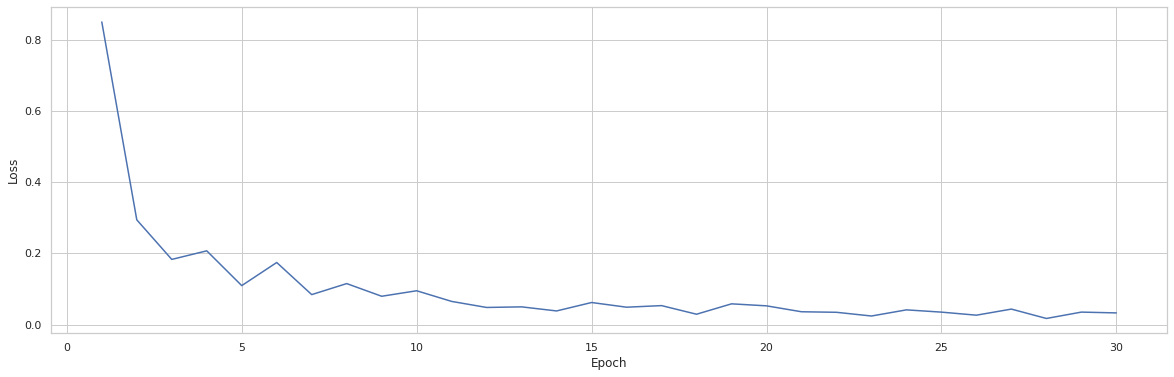

In [8]:
dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer, scheduler = loader.load_scheduler_optimizer(dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA)

output.clear()

manager.train_network_without_adaptation(dann, util)

In [9]:
manager.test_network(dann, dataloader_target)

100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Test Accuracy: 0.48095703125


<Figure size 432x288 with 0 Axes>

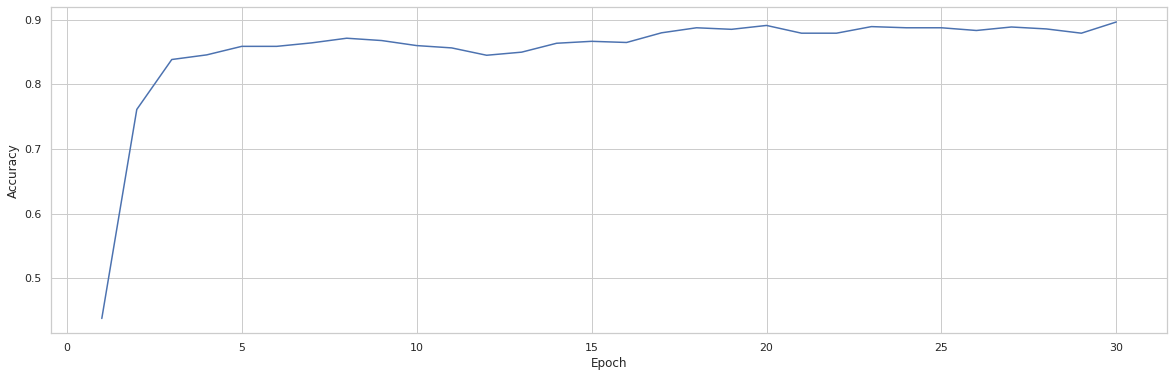

<Figure size 432x288 with 0 Axes>

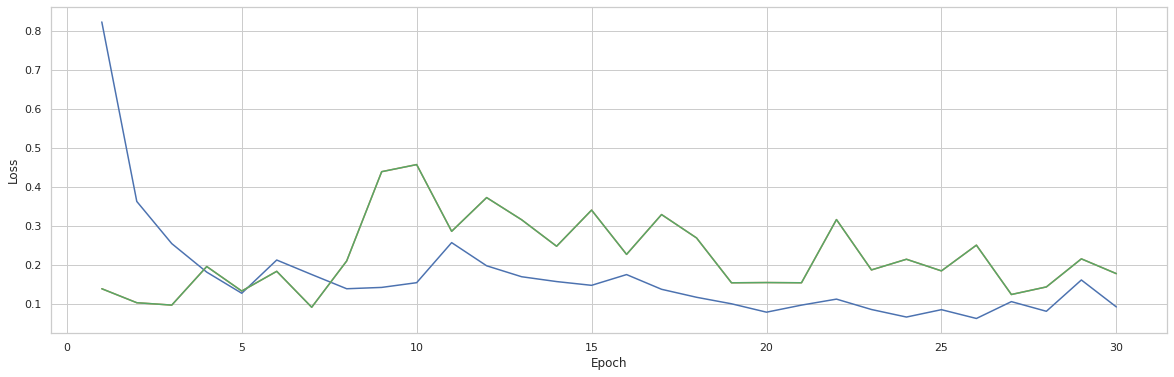

In [10]:
dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer, scheduler = loader.load_scheduler_optimizer(dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA)

output.clear()

discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

LAMBDA=0.5

manager.train_network_with_adaptation(dann, util, LAMBDA)

In [11]:
manager.test_network(dann, dataloader_target)

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Test Accuracy: 0.4365234375


In [12]:
# hyperparameters_set = loader.load_hyperparameters()  LR = ["...", "...", "..."], ALPHA = ["...", "...", "..."]

# for lr in hyperparameters_set[0]:

#   for alpha in hyperparameters_set[1]:

#     dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
#     loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
#     optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA)

#     output.clear()

#     discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Art Painting

#     discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

#     manager.train_network_with_adaptation_grid_search(dann, util, alpha, dataloader_target_cartoon)

#     LAMBDA=0.5
#     already_recomputed_short_discriminator_target_labels = False

#     dann = dann.to(DEVICE) 
#     cudnn.benchmark
#     current_step = 0

#     classifier_accuracies = []
#     classifier_losses = []
#     discriminator_source_losses = []
#     discriminator_target_losses = []
#     short_discriminator_target_labels = []

#     # Start iterating over the epochs
#     for epoch in range(NUM_EPOCHS):
      
#       print("Epoch " + str(epoch+1))
      
#       running_corrects = 0

#       for index, (source_images, labels) in enumerate(dataloader_source):

#         dann.train()

#         target_images, target_set = sample_target(current_step, BATCH_SIZE)

#         source = source_images.to(DEVICE)
#         target = target_images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         optimizer.zero_grad()

#         # Forward source data to the classifier branch of the network
#         classifier_output = dann(source)
#         classifier_loss = loss_classifier(classifier_output, labels)
#         classifier_loss.backward()

#         # Get predictions
#         _, preds = torch.max(classifier_output.data, 1)

#         # Update Corrects
#         running_corrects += torch.sum(preds == labels.data).data.item()

#         # Forward source data to the discriminator branch of the network
#         discriminator_output_source = dann(source, LAMBDA)
#         discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
#         discriminator_loss_source.backward()

#         # Forward target data to the discriminator branch of the network
#         discriminator_output_target = dann(target, LAMBDA)
#         if BATCH_SIZE != len(discriminator_output_target):

#           # Define short_discriminator_target_labels if not defined yet
#           short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
        
#           discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      
#         else:
          
#           discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

#         discriminator_loss_target.backward()

#         optimizer.step()

#       scheduler.step() 

#       # Calculate Accuracy
#       accuracy = running_corrects / float(len(train_dataset))
      
#       print("Classifier accuracy: ", str(accuracy))
#       print("Classifier loss: ", str(classifier_loss.item()))
#       print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
#       print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

#       classifier_accuracies.append( (epoch + 1, accuracy) )
#       classifier_losses.append( (epoch + 1, classifier_loss.item()) )
#       discriminator_source_losses.append( (epoch + 1, discriminator_loss_source.item()) )
#       discriminator_target_losses.append( (epoch + 1, discriminator_loss_target.item()) )

#     output.clear()
#     loader.plot_accuracies(classifier_accuracies)
#     loader.plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses)

Epoch 1
Classifier accuracy:  0.8910179640718563
Classifier loss:  0.08770139515399933
Discriminator (source) loss:  0.19195303320884705
Discriminator (target) loss:  0.20521201193332672
Epoch 2


KeyboardInterrupt: ignored